In [1]:

# Intent-Based Product Search System
# AI Hackathon Implementation

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from tqdm.notebook import tqdm
import torch.nn as nn
from torch.optim import AdamW


In [2]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
# 1. Load and Explore the Dataset
print("Loading WDC Products 2017 dataset...")
dataset = load_dataset("wdc/products-2017", trust_remote_code=True) 

# Print dataset info
print(dataset)

Loading WDC Products 2017 dataset...
DatasetDict({
    train: Dataset({
        features: ['pair_id', 'label', 'id_left', 'category_left', 'cluster_id_left', 'brand_left', 'title_left', 'description_left', 'price_left', 'specTableContent_left', 'id_right', 'category_right', 'cluster_id_right', 'brand_right', 'title_right', 'description_right', 'price_right', 'specTableContent_right'],
        num_rows: 6475
    })
    test: Dataset({
        features: ['pair_id', 'label', 'id_left', 'category_left', 'cluster_id_left', 'brand_left', 'title_left', 'description_left', 'price_left', 'specTableContent_left', 'id_right', 'category_right', 'cluster_id_right', 'brand_right', 'title_right', 'description_right', 'price_right', 'specTableContent_right'],
        num_rows: 1100
    })
    validation: Dataset({
        features: ['pair_id', 'label', 'id_left', 'category_left', 'cluster_id_left', 'brand_left', 'title_left', 'description_left', 'price_left', 'specTableContent_left', 'id_right', 'cate

In [4]:
# Let's look at the training data
# train_df = pd.DataFrame(dataset['train'])

# Take only the first 100 rows of the training data
train_df = pd.DataFrame(dataset['train'][:100])

print("\nTraining Data Sample:")
print(train_df.head())


Training Data Sample:
             pair_id  label   id_left              category_left  \
0  14219585#11723285      0  14219585  Computers_and_Accessories   
1  12092252#16476204      0  12092252  Computers_and_Accessories   
2  10693245#16856034      1  10693245  Computers_and_Accessories   
3    2042153#7421086      0   2042153  Computers_and_Accessories   
4  11210178#16709272      1  11210178  Computers_and_Accessories   

   cluster_id_left       brand_left  \
0           521249             None   
1           222681  "HP Enterprise"   
2          1404813             None   
3           212917            "MIO"   
4           150997            "MSI"   

                                          title_left  \
0   "Apple - Mac Pro Desktop Computer 6-Core Inte...   
1   "DG0300FARVV HP 300-GB 6G 10K 2.5 DP SAS", "N...   
2   "HP BL460c G7 Intel Xeon E5607 Processor Kit ...   
3   "MIO SD1GB-C230 BXP 1GB 9p SD Secure Digital ...   
4   "MSI - GeForce GTX 1080 8GB GAMING X 8G Video... 

In [5]:


# Select the required columns
required_columns = ['label', 'id_left', 'category_left', 'cluster_id_left', 'brand_left', 
                   'title_left', 'description_left', 'price_left', 'specTableContent_left']

# Check if all required columns exist in the dataset
all_columns = train_df.columns.tolist()
print("\nAvailable columns in the dataset:", all_columns)

# Filter the dataframe to keep only the required columns
if all(col in all_columns for col in required_columns):
    filtered_train_df = train_df[required_columns]
    print("\nFiltered training data columns:")
    print(filtered_train_df.columns)
else:
    missing_cols = [col for col in required_columns if col not in all_columns]
    print(f"\nWarning: Missing columns: {missing_cols}")
    # Use only available columns from the required list
    available_required_cols = [col for col in required_columns if col in all_columns]
    filtered_train_df = train_df[available_required_cols]
    print("\nProceeding with available columns:")
    print(filtered_train_df.columns)


Available columns in the dataset: ['pair_id', 'label', 'id_left', 'category_left', 'cluster_id_left', 'brand_left', 'title_left', 'description_left', 'price_left', 'specTableContent_left', 'id_right', 'category_right', 'cluster_id_right', 'brand_right', 'title_right', 'description_right', 'price_right', 'specTableContent_right']

Filtered training data columns:
Index(['label', 'id_left', 'category_left', 'cluster_id_left', 'brand_left',
       'title_left', 'description_left', 'price_left',
       'specTableContent_left'],
      dtype='object')


In [6]:
train_df.columns = [col.replace('_left', '') for col in train_df.columns]

columns_to_keep = [
    'label', 'id', 'category', 'cluster_id', 'brand',
    'title', 'description', 'price', 'specTableContent'
]
train_df = train_df[columns_to_keep]

In [7]:
# Basic data exploration
print("\nData Information:")
print(f"Training data shape: {filtered_train_df.shape}")
print("\nDescriptive Statistics:")
print(filtered_train_df.describe(include='all'))



Data Information:
Training data shape: (100, 9)

Descriptive Statistics:
             label       id_left              category_left  cluster_id_left  \
count   100.000000  1.000000e+02                        100     1.000000e+02   
unique         NaN           NaN                          5              NaN   
top            NaN           NaN  Computers_and_Accessories              NaN   
freq           NaN           NaN                         95              NaN   
mean      0.140000  1.066210e+07                        NaN     3.632670e+06   
std       0.348735  5.301614e+06                        NaN     5.169345e+06   
min       0.000000  1.043300e+04                        NaN     3.209000e+03   
25%       0.000000  6.500062e+06                        NaN     2.925412e+05   
50%       0.000000  1.179599e+07                        NaN     6.096160e+05   
75%       0.000000  1.530262e+07                        NaN     7.529747e+06   
max       1.000000  1.754897e+07              

In [8]:
# Check for missing values
print("\nMissing values in each column:")
print(filtered_train_df.isnull().sum())

# Check label distribution (if label is available)
if 'label' in filtered_train_df.columns:
    print("\nLabel distribution:")
    print(filtered_train_df['label'].value_counts())


Missing values in each column:
label                     0
id_left                   0
category_left             0
cluster_id_left           0
brand_left               41
title_left                0
description_left         19
price_left               81
specTableContent_left    76
dtype: int64

Label distribution:
label
0    86
1    14
Name: count, dtype: int64


In [9]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [10]:
# Download NLTK resources if not already available
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

In [11]:
# Data preprocessing function
def preprocess_text(text):
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join tokens back into text
    text = ' '.join(tokens)
    
    return text

# Apply preprocessing to relevant columns
print("\nPreprocessing text columns...")
train_df['clean_title'] = train_df['title'].apply(preprocess_text)
train_df['clean_description'] = train_df['description'].apply(preprocess_text)
train_df['clean_brand'] = train_df['brand'].apply(preprocess_text)


Preprocessing text columns...


In [12]:
# Create a combined text field for modeling
train_df['combined_text'] = train_df['clean_title'] + ' ' + train_df['clean_description'] + ' ' + train_df['clean_brand']


In [13]:
# Remove rows with empty combined text
train_df = train_df[train_df['combined_text'].str.strip() != '']
print(f"Dataset shape after preprocessing: {train_df.shape}")

Dataset shape after preprocessing: (100, 13)


In [14]:
from sklearn.preprocessing import LabelEncoder

In [15]:
# Create a label encoder for categories
label_encoder = LabelEncoder()
train_df['category_encoded'] = label_encoder.fit_transform(train_df['category'])
num_categories = len(label_encoder.classes_)
print(f"Number of unique categories: {num_categories}")

Number of unique categories: 5


In [16]:
# Define a custom dataset class
class ProductDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }



In [17]:
# Split data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['combined_text'].tolist(),
    train_df['category_encoded'].tolist(),
    test_size=0.2,
    random_state=42
)

In [18]:
from transformers import BertTokenizer
from transformers import BertModel

In [19]:
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create datasets
train_dataset = ProductDataset(train_texts, train_labels, tokenizer)
val_dataset = ProductDataset(val_texts, val_labels, tokenizer)

# Create data loaders
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

In [20]:
class IntentBasedProductSearch(torch.nn.Module):
    def __init__(self, num_labels):
        super(IntentBasedProductSearch, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(self.bert.config.hidden_size, num_labels)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

In [21]:
# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = IntentBasedProductSearch(num_categories)
model.to(device)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

In [22]:
# Training function
def train_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    
    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})
    
    return total_loss / len(dataloader)

# Evaluation function
def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs, labels)
            
            total_loss += loss.item()
            
            _, preds = torch.max(outputs, dim=1)
            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.size(0)
    
    accuracy = correct_predictions / total_predictions
    avg_loss = total_loss / len(dataloader)
    
    return avg_loss, accuracy

# Function to make predictions for intent-based search
def search_products(query, model, tokenizer, label_encoder, df, device, top_k=5):
    model.eval()
    
    # Preprocess the query
    processed_query = preprocess_text(query)
    
    # Tokenize the query
    encoding = tokenizer(
        processed_query,
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Get model predictions
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    
    # Get top categories based on probabilities
    top_probs, top_categories = torch.topk(probabilities, k=top_k)
    
    results = []
    for i in range(top_k):
        category_idx = top_categories[0][i].item()
        category_name = label_encoder.inverse_transform([category_idx])[0]
        probability = top_probs[0][i].item()
        
        # Get sample products from this category
        category_products = df[df['category'] == category_name].head(3)
        products = []
        for _, product in category_products.iterrows():
            products.append({
                'title': product['title'],
                'brand': product['brand'],
                'price': product['price']
            })
        
        results.append({
            'category': category_name,
            'probability': probability,
            'sample_products': products
        })
    
    return results


In [23]:
# Train the model
num_epochs = 3
print(f"Starting training for {num_epochs} epochs...")

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    
    # Training
    train_loss = train_epoch(model, train_dataloader, optimizer, loss_fn, device)
    train_losses.append(train_loss)
    
    # Validation
    val_loss, val_accuracy = evaluate(model, val_dataloader, loss_fn, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")

Starting training for 3 epochs...

Epoch 1/3


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.9343
Validation Loss: 0.6170

Epoch 2/3


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6615
Validation Loss: 0.4869

Epoch 3/3


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.5469
Validation Loss: 0.2927


In [24]:
# Save the model
torch.save(model.state_dict(), 'intent_product_search_model.pt')
print("Model saved as 'intent_product_search_model.pt'")

Model saved as 'intent_product_search_model.pt'


Training metrics plot saved as 'training_metrics.png'


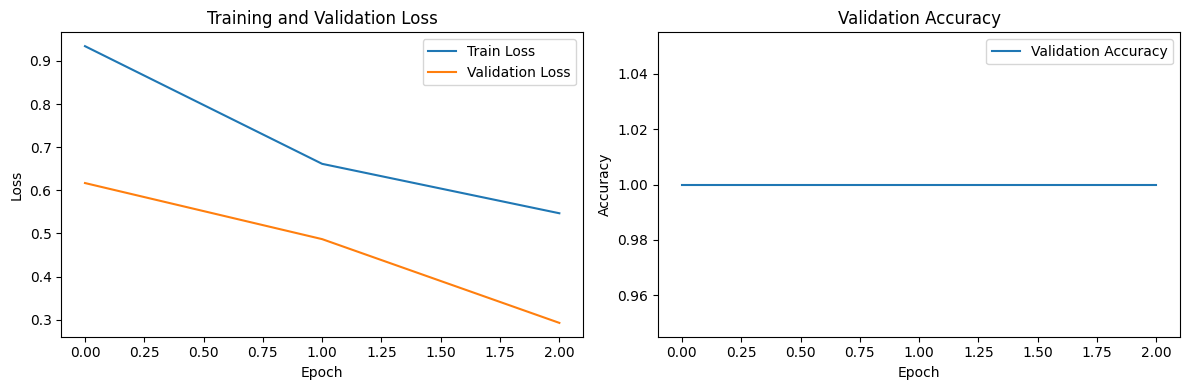

In [25]:
# Plot training metrics
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')

plt.tight_layout()
plt.savefig('training_metrics.png')
print("Training metrics plot saved as 'training_metrics.png'")

In [28]:
train_df.head()

,label,id,category,cluster_id,brand,title,description,price,specTableContent,clean_title,clean_description,clean_brand,combined_text,category_encoded
0,0,14219585,Computers_and_Accessories,521249,None,"""Apple - Mac Pro Desktop Computer 6-Core Inte...","""Apple Mac Pro MD878LL/A Desktop: Designed for...",None,None,apple mac pro desktop computer core intel xeon...,apple mac pro mdlla desktop designed professio...,,apple mac pro desktop computer core intel xeon...,2
1,0,12092252,Computers_and_Accessories,222681,"""HP Enterprise""","""DG0300FARVV HP 300-GB 6G 10K 2.5 DP SAS"", ""N...","""Description:2 x 300GB 2.5-inch Serial Attache...",None,Specifications: Category Proliant HardDrive S...,dgfarvv hp gb g k dp sa null price dgfarvvpack...,description x gb inch serial attached scsi sas...,hp enterprise,dgfarvv hp gb g k dp sa null price dgfarvvpack...,2
2,1,10693245,Computers_and_Accessories,1404813,None,"""HP BL460c G7 Intel Xeon E5607 Processor Kit ...",None,None,Categorie Processors Merk HP Product HP BL460...,hp blc g intel xeon e processor kit prijzen nl...,,,hp blc g intel xeon e processor kit prijzen nl...,2
3,0,2042153,Computers_and_Accessories,212917,"""MIO""","""MIO SD1GB-C230 BXP 1GB 9p SD Secure Digital ...","""SD1GB-C230 BXP 1GB 9p SD Secure Digital Card...","""USD"", ""4.85""",None,mio sdgbc bxp gb p sd secure digital card x us...,sdgbc bxp gb p sd secure digital card x used w...,mio,mio sdgbc bxp gb p sd secure digital card x us...,2
4,1,11210178,Computers_and_Accessories,150997,"""MSI""","""MSI - GeForce GTX 1080 8GB GAMING X 8G Video...",None,None,None,msi geforce gtx gb gaming x g video card card ...,,msi,msi geforce gtx gb gaming x g video card card ...,2


In [30]:
example_queries = [
    "I need a new smartphone",
    "looking for cheap laptops",
    "best kitchen appliances for small spaces",
    "comfortable running shoes"
]

print("\nExample intent-based product searches:")
for query in example_queries:
    print(f"\nQuery: '{query}'")
    results = search_products(query, model, tokenizer, label_encoder, train_df, device)
    
    print("Top categories:")
    for i, result in enumerate(results):
        print(f"{i+1}. {result['category']} (Confidence: {result['probability']:.4f})")
        print("   Sample products:")
        for product in result['sample_products']:
            print(f"   - {product['title']} by {product['brand']}, Price: {product['price']}")


Example intent-based product searches:

Query: 'I need a new smartphone'
Top categories:
1. Computers_and_Accessories (Confidence: 0.6760)
   Sample products:
   -  "Apple - Mac Pro Desktop Computer 6-Core Intel® Xeon® Processor 16GB Memory 256GB Flash Storage Black"@en-US by None, Price: None
   -  "DG0300FARVV HP 300-GB 6G 10K 2.5 DP SAS", "Null" Price DG0300FARVV-2Pack" "New DG0300FARVV SAS 2 Pack Wholesale by "HP Enterprise", Price: None
   -  "HP BL460c G7 Intel Xeon E5607 Processor Kit - Prijzen "@NL Tweakers"@NL by None, Price: None
2. Camera_and_Photo (Confidence: 0.1305)
   Sample products:
   -  "Sandisk Extreme microSDHC 64Gb Type 10" 10 acheter et offres sur Scubastore" by "Sandisk", Price: None
3. Tools_and_Home_Improvement (Confidence: 0.0734)
   Sample products:
   -  "48-32-4006" " Shop For Drill Bits. - Dale Electric Supply Co. by "
														MILWAUKEE ELECTRIC TOOL CORP.													", Price: None
4. Office_Products (Confidence: 0.0661)
   Sample products:
   -  